# California Housing – End to End Regression

This one notebook shows everything: explore data, clean it, create features, train 3 regression models (Linear, Ridge, Lasso), compare metrics, and save the best model.

## 1. Imports

In [1]:
# We import all libraries we need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# Set a simple pretty plot style
sns.set(style='whitegrid', context='notebook')

## 2. Load Data

In [2]:
# We read the CSV file (raw data)
DATA_PATH = '../data/raw/housing.csv'
df = pd.read_csv(DATA_PATH)
# Show first 5 rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. Basic Info

In [3]:
# We look at shape and column names
print('Shape (rows, columns):', df.shape)
print('Columns:', df.columns.tolist())
# We look at info to see data types
print('\nData Types and Non-Null Counts:')
df.info()

Shape (rows, columns): (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 4. Basic Statistics and Missing Values

In [4]:
# Show basic statistics
stats = df.describe().T
missing = df.isna().sum()
print('Missing values per column:')
print(missing)
stats

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


## 5. Fill Missing Bedrooms

In [5]:
# Fill missing total_bedrooms with median
bedrooms_median = df['total_bedrooms'].median()
df['total_bedrooms'] = df['total_bedrooms'].fillna(bedrooms_median)
print('Missing total_bedrooms after fill:', df['total_bedrooms'].isna().sum())

Missing total_bedrooms after fill: 0


## 6. Create Engineered Features

In [6]:
# New ratio features to help the model
# Average rooms per household
df['rooms_per_household'] = df['total_rooms'] / df['households']
# Bedrooms per room
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
# Population per household
df['population_per_household'] = df['population'] / df['households']
# Show first 5 rows of new columns
df[['rooms_per_household','bedrooms_per_room','population_per_household']].head()

,rooms_per_household,bedrooms_per_room,population_per_household
0,6.984127,0.146591,2.555556
1,6.238137,0.155797,2.109842
2,8.288136,0.129516,2.802260
3,5.817352,0.184458,2.547945
4,6.281853,0.172096,2.181467


## 7. Plot Distributions

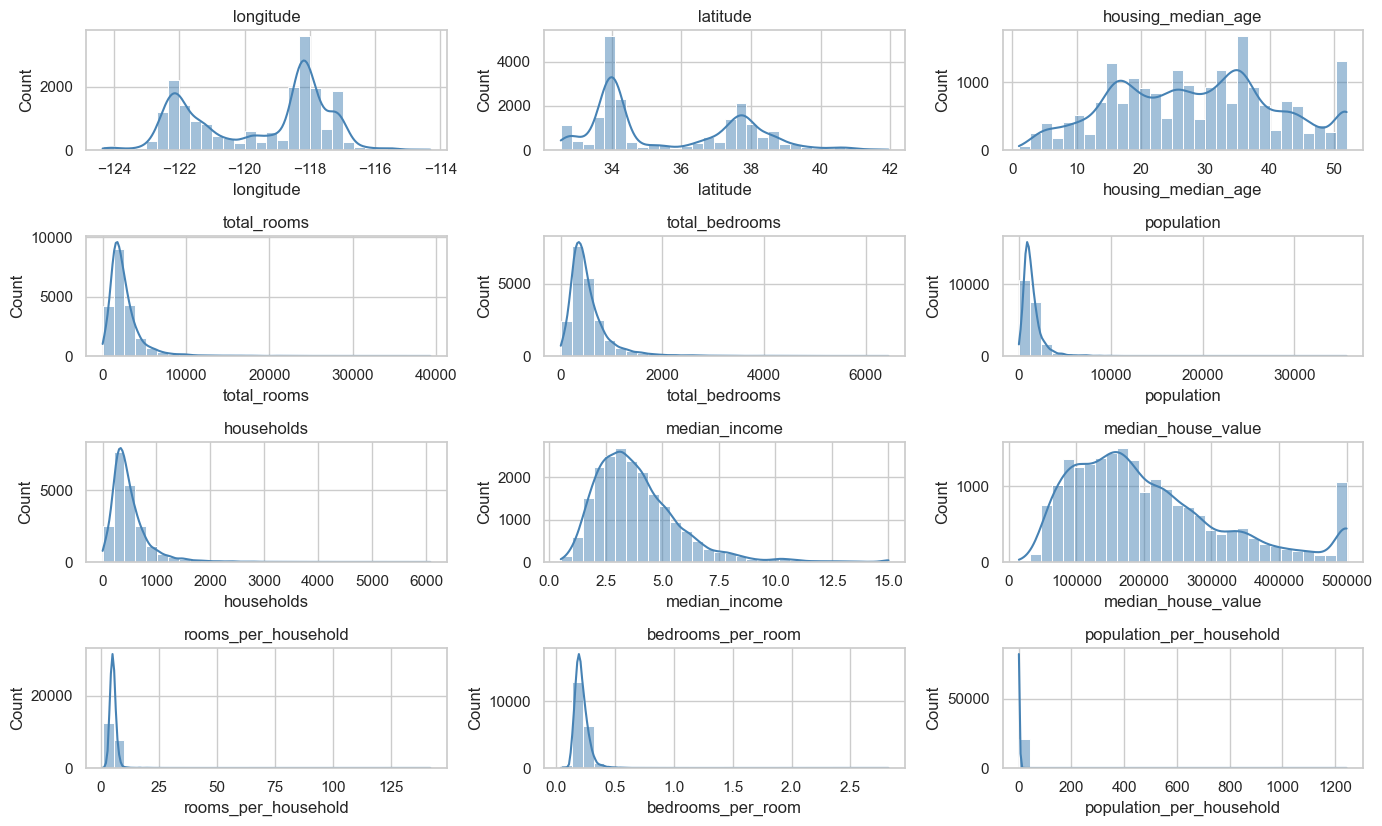

In [7]:
# Histograms of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='steelblue')
    plt.title(col)
plt.tight_layout()
plt.show()

## 8. Ocean Proximity Counts

In [8]:
# Count rows per category
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

## 9. Boxplot House Value by Ocean Proximity

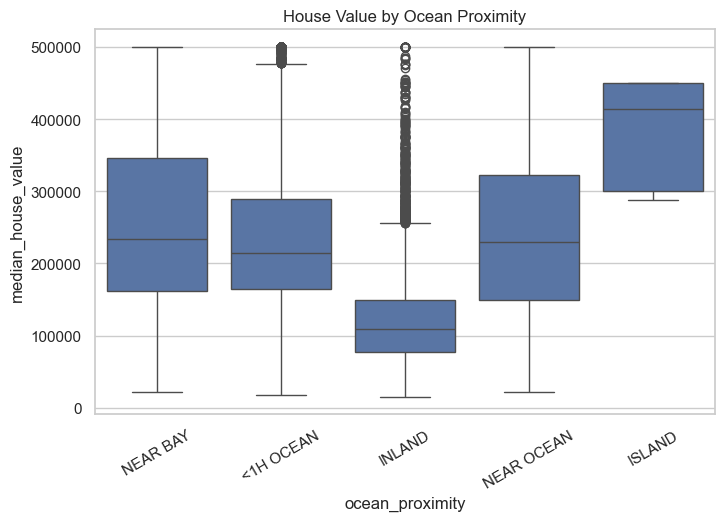

In [9]:
# Boxplot of house value across categories
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')
plt.title('House Value by Ocean Proximity')
plt.xticks(rotation=30)
plt.show()

## 10. Correlation Heatmap

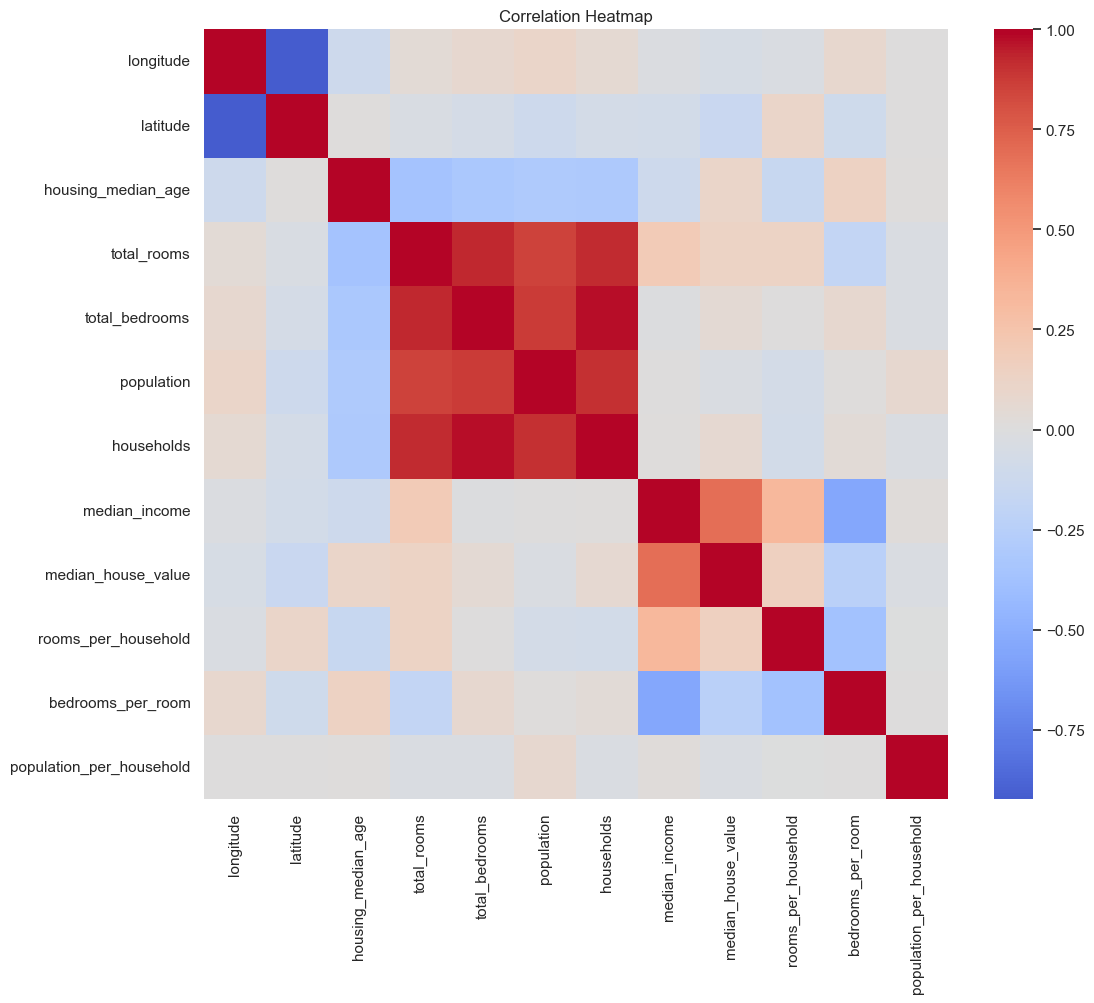

In [10]:
# Correlation matrix of numeric features
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## 11. Prepare Data For Modeling

In [11]:
# One-hot encode ocean_proximity (drop_first=True to avoid dummy trap)
df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
# Separate features X and target y
target_col = 'median_house_value'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]
X.shape, y.shape

((20640, 15), (20640,))

## 12. Train / Test Split

In [12]:
# Split data (20% test) for fair evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16512, 15), (4128, 15))

## 13. Scale Numeric Features

In [13]:
# Standardize numeric columns (mean 0, std 1)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_train_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,1.272587,-1.372811,0.348490,0.222569,0.211228,0.768276,0.322906,-0.326196,-0.174916,-0.211785,0.051376,False,False,False,True
8267,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843,-0.402835,0.342185,-0.117362,False,False,False,True
17445,-0.447603,-0.460146,-1.952710,-0.342597,-0.495226,-0.449818,-0.430461,0.144701,0.088216,-0.661658,-0.032280,False,False,False,True
14265,1.232698,-1.382172,0.586545,-0.561490,-0.409306,-0.007434,-0.380587,-1.017864,-0.600015,0.783032,0.077507,False,False,False,True
2271,-0.108551,0.532084,1.142008,-0.119565,-0.256559,-0.485877,-0.314962,-0.171488,0.349007,-0.550364,-0.068832,True,False,False,False


## 14. Define Metrics Helper

In [14]:
# Function to compute R2, MAE, RMSE
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mae, rmse

## 15. Train Linear Regression

In [15]:
# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_pred = lin_reg.predict(X_test_scaled)
lin_r2, lin_mae, lin_rmse = compute_metrics(y_test, lin_pred)
print('Linear Regression -> R2:', lin_r2, 'MAE:', lin_mae, 'RMSE:', lin_rmse)

Linear Regression -> R2: 0.5970176824350761 MAE: 50888.66001572008 RMSE: 72668.53837868226


c:\Learn Programming\MachineLearning\california-housing-regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 16. Train Ridge Regression

In [16]:
# Train Ridge Regression model
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_r2, ridge_mae, ridge_rmse = compute_metrics(y_test, ridge_pred)
print('Ridge Regression -> R2:', ridge_r2, 'MAE:', ridge_mae, 'RMSE:', ridge_rmse)

Ridge Regression -> R2: 0.5968980475023374 MAE: 50898.81157442669 RMSE: 72679.32427447119


c:\Learn Programming\MachineLearning\california-housing-regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 17. Train Lasso Regression

In [17]:
# Train Lasso Regression model
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_r2, lasso_mae, lasso_rmse = compute_metrics(y_test, lasso_pred)
print('Lasso Regression -> R2:', lasso_r2, 'MAE:', lasso_mae, 'RMSE:', lasso_rmse)

Lasso Regression -> R2: 0.597017242592792 MAE: 50888.763963363446 RMSE: 72668.57803636177


c:\Learn Programming\MachineLearning\california-housing-regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 18. Compare Metrics

In [18]:
# Put all results in a DataFrame for easy view
results = pd.DataFrame([
    {'model': 'LinearRegression', 'R2': lin_r2, 'MAE': lin_mae, 'RMSE': lin_rmse},
    {'model': 'Ridge', 'R2': ridge_r2, 'MAE': ridge_mae, 'RMSE': ridge_rmse},
    {'model': 'Lasso', 'R2': lasso_r2, 'MAE': lasso_mae, 'RMSE': lasso_rmse}
])
results.sort_values('R2', ascending=False)

,model,R2,MAE,RMSE
0,LinearRegression,0.597018,50888.660016,72668.538379
2,Lasso,0.597017,50888.763963,72668.578036
1,Ridge,0.596898,50898.811574,72679.324274


## 19. Select Best Model and Save

In [19]:
# Pick model with highest R2
best_row = results.loc[results['R2'].idxmax()]
best_name = best_row['model']
print('Best model is:', best_name)
model_map = {
    'LinearRegression': lin_reg,
    'Ridge': ridge,
    'Lasso': lasso
}
best_model = model_map[best_name]
# Save model and preprocessing artifacts
engineered_features = ['rooms_per_household','bedrooms_per_room','population_per_household']
artifact = {
    'model_name': best_name,
    'model': best_model,
    'scaler': scaler,
    'numeric_columns': numeric_cols.tolist(),
    'final_columns': X_train_scaled.columns.tolist(),
    'bedrooms_median': bedrooms_median,
    'engineered_features': engineered_features
}
joblib.dump(artifact, '../models/best_model.pkl')
print('Saved best model to models/best_model.pkl')

Best model is: LinearRegression
Saved best model to models/best_model.pkl


## 20. Quick Demo Predict (Single Row)

In [20]:
# Make a simple fake input (we pick median-ish values)
example = {
    'longitude': -120.0,
    'latitude': 36.0,
    'housing_median_age': 30.0,
    'total_rooms': 2000.0,
    'total_bedrooms': 400.0,
    'population': 800.0,
    'households': 300.0,
    'median_income': 4.0,
    # We choose one category (NEAR BAY absent because drop_first, so use others) -> we set all dummy later
    'ocean_proximity_INLAND': 0,
    'ocean_proximity_ISLAND': 0,
    'ocean_proximity_NEAR OCEAN': 0,
    'ocean_proximity_<1H OCEAN': 0
}
# Compute engineered features for this single row
example['rooms_per_household'] = example['total_rooms'] / example['households']
example['bedrooms_per_room'] = example['total_bedrooms'] / example['total_rooms']
example['population_per_household'] = example['population'] / example['households']

# Build DataFrame with one row
ex_df = pd.DataFrame([example])
# Align columns (missing ones fill with 0)
for col in artifact['final_columns']:
    if col not in ex_df.columns:
        ex_df[col] = 0
# Order columns like training
ex_df = ex_df[artifact['final_columns']]
# Scale numeric columns
ex_df[artifact['numeric_columns']] = artifact['scaler'].transform(ex_df[artifact['numeric_columns']])
# Predict
pred_price = artifact['model'].predict(ex_df)[0]
print('Predicted price (USD):', pred_price)
print('Predicted price (TND approx):', pred_price * 3.15)

Predicted price (USD): 228346.80513286707
Predicted price (TND approx): 719292.4361685313


## 21. Summary

In [21]:
# We print a simple summary line
print('We explored data, cleaned it, created features, trained 3 models, compared metrics, saved best model, and demoed prediction.')

We explored data, cleaned it, created features, trained 3 models, compared metrics, saved best model, and demoed prediction.
